# **Proyecto Final: Modelado Geoespacial del Riesgo de Inundación en el Ecuador**
## **Asignatura:** Inteligencia Artificial y Ciencia de Datos
**Integrantes:**
* Bayron Zosimo Tenorio Ferrer
* Karla Patricia Solórzano Parra
* Juren David Rodriguez Bautista
* Mayerly Kristel Veloz Alburquerque

---

### **1. Introducción y Alcance**
El Ecuador enfrenta una alta vulnerabilidad ante eventos hidrometeorológicos, exacerbada por la diversidad de su orografía. Este proyecto propone un enfoque de **Machine Learning Supervisado** para la zonificación del riesgo de inundación a nivel de **parroquia** (unidad territorial mínima de planificación).

El objetivo es entrenar un clasificador capaz de predecir la categoría de riesgo (**Bajo, Medio, Alto**) basándose en características topográficas e hidrológicas estructurales. Dada la criticidad del problema, se prioriza la maximización del **Recall (Sensibilidad)** para minimizar los falsos negativos (zonas de riesgo no detectadas).

### **2. Arquitectura de Datos y Fuentes**
Para garantizar la validez científica del estudio, se construyó un dataset multidimensional integrando fuentes oficiales y satelitales verificadas:

1.  **Marco Geoespacial (División Política):**
    * *Fuente:* **Humanitarian Data Exchange (HDX) - COD-AB.**
    * *Uso:* Polígonos oficiales de límites parroquiales y códigos DPA (División Político-Administrativa) para asegurar la interoperabilidad con sistemas estatales.
2.  **Topografía (Variables Predictoras Principales):**
    * *Fuente:* **OpenTopography (SRTM Global DEM, 30m de resolución).**
    * *Procesamiento:* Se realizó un análisis de estadísticas zonales (`rasterstats`) para extraer la Altitud Media, Mínima, Máxima y el Rango Altitudinal de cada parroquia.
3.  **Hidrografía (Distancia a Cuerpos de Agua):**
    * *Fuente:* **Humanitarian OpenStreetMap Team (HOT-OSM).**
    * *Procesamiento:* Cálculo de distancia euclidiana mínima desde el centroide parroquial a la red hídrica principal.
4.  **Control de Calidad (QA/QC):**
    * *Herramienta:* **ArcGIS.**
    * *Uso:* Validación cruzada de la toponimia y códigos DPA para garantizar la integridad referencial del dataset final.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Modelos
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Métricas
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    roc_auc_score
)

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

print(" Librerías importadas exitosamente!")

 Librerías importadas exitosamente!


In [61]:
!pip freeze > requirements.txt

### Cargar y Exploracion Inicial del Dataset

In [11]:
# Cargar dataset
df = pd.read_csv('dataset_riesgo_inundacion_FINAL.csv')

In [12]:
df.head()

,DPA_PARROQ,DPA_DESPAR,DPA_CANTON,DPA_DESCAN,DPA_PROVIN,DPA_DESPRO,altitud_media_m,altitud_min_m,altitud_max_m,rango_altitudinal_m,riesgo_inundacion
0,010150,CUENCA,0101,CUENCA,01,AZUAY,2551.95,2325.500000,2862.738281,537.24,Bajo
1,010151,BAÑOS,0101,CUENCA,01,AZUAY,3495.57,2572.187500,4141.153320,1568.97,Bajo
2,010152,CUMBE,0101,CUENCA,01,AZUAY,3007.06,2625.938721,3481.828613,855.89,Bajo
3,010153,CHAUCHA,0101,CUENCA,01,AZUAY,2848.01,192.770004,4445.888672,4253.12,Bajo
4,010154,CHECA (JIDCAY),0101,CUENCA,01,AZUAY,3597.18,2619.350586,4297.227051,1677.88,Bajo


### **Preprocesamiento y Limpieza de Datos**

**Integridad y Duplicados**
Se verificó la unicidad de las instancias utilizando el código `DPA_PARROQ` como llave primaria. Esto evita el sesgo de frecuencia que ocurriría si una misma parroquia estuviera representada múltiples veces.

**Estrategia de Imputación (Spatial Coherence Imputation)**
Se detectaron valores nulos en variables topográficas. En lugar de la eliminación (que reduciría la representatividad territorial), se aplicó una imputación basada en la **Media Provincial**.
* *Justificación Técnica:* Se asume el principio de **autocorrelación espacial** (Primera Ley de la Geografía de Tobler): "Todo está relacionado con todo lo demás, pero las cosas cercanas están más relacionadas que las distantes".

**Nota Técnica sobre la Dimensión Temporal**
El presente estudio adopta un diseño **transversal (cross-sectional)** de zonificación de riesgo estructural.
* *Justificación:* El riesgo de inundación se modela aquí como una vulnerabilidad inherente a la geomorfología (altitud, pendiente) y ubicación de la parroquia, factores que son invariantes en el corto plazo. Por ello, no se requieren series de tiempo (`datetime`) para el entrenamiento, sino promedios climáticos históricos implícitos en la etiqueta de riesgo.

In [13]:
# LIMPIEZA: MANEJO DE DUPLICADOS

# Verificación de integridad usando el código de parroquia como clave única
duplicados = df.duplicated(subset=['DPA_PARROQ']).sum()
print(f"Duplicados iniciales detectados: {duplicados}")

if duplicados > 0:
    print("Eliminando registros duplicados...")
    df = df.drop_duplicates(subset=['DPA_PARROQ'], keep='first')
else:
    print(" Integridad verificada: No existen parroquias duplicadas.")

Duplicados iniciales detectados: 0
 Integridad verificada: No existen parroquias duplicadas.


**Análisis Exploratorio de Datos (EDA)**

In [14]:
print("\n" + "-"*80)
print("Información de los datos:")
print(df.info())


--------------------------------------------------------------------------------
Información de los datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DPA_PARROQ           1036 non-null   object 
 1   DPA_DESPAR           1036 non-null   object 
 2   DPA_CANTON           1036 non-null   object 
 3   DPA_DESCAN           1036 non-null   object 
 4   DPA_PROVIN           1036 non-null   object 
 5   DPA_DESPRO           1036 non-null   object 
 6   altitud_media_m      1012 non-null   float64
 7   altitud_min_m        1012 non-null   float64
 8   altitud_max_m        1012 non-null   float64
 9   rango_altitudinal_m  1012 non-null   float64
 10  riesgo_inundacion    1036 non-null   object 
dtypes: float64(4), object(7)
memory usage: 89.2+ KB
None


In [15]:
print("\n" + "-"*80)
print("Estadísticas descriptivas:")
print(df.describe())


--------------------------------------------------------------------------------
Estadísticas descriptivas:
       altitud_media_m  altitud_min_m  altitud_max_m  rango_altitudinal_m
count      1012.000000    1012.000000    1012.000000          1012.000000
mean       1616.941700    1059.953574    2404.090423          1344.136818
std        1248.710723    1008.661860    1608.451833          1020.326795
min           2.100000      -6.525248      14.197462             8.070000
25%         267.937500     116.461031     574.143250           450.745000
50%        1563.540000     742.000000    2789.521606          1290.650000
75%        2786.205000    2125.000000    3762.337219          2049.082500
max        4009.480000    3171.920654    6262.506836          5189.280000


In [16]:
## Verificar valores nulos

print("\n--- Valores Nulos ---")
nulos = df.isnull().sum()
print(nulos[nulos > 0])
print(f"\nTotal de valores nulos: {df.isnull().sum().sum()}")
print(f"Porcentaje de nulos: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")


--- Valores Nulos ---
altitud_media_m        24
altitud_min_m          24
altitud_max_m          24
rango_altitudinal_m    24
dtype: int64

Total de valores nulos: 96
Porcentaje de nulos: 0.84%


In [17]:
# Análisis de la variable objetivo
print("\n--- Distribución de la Variable Objetivo: riesgo_inundacion ---")
print(df['riesgo_inundacion'].value_counts())
print("\nProporciones:")
print(df['riesgo_inundacion'].value_counts(normalize=True))



--- Distribución de la Variable Objetivo: riesgo_inundacion ---
riesgo_inundacion
Bajo     719
Medio    164
Alto     153
Name: count, dtype: int64

Proporciones:
riesgo_inundacion
Bajo     0.694015
Medio    0.158301
Alto     0.147683
Name: proportion, dtype: float64



--- Distribución de la Variable Objetivo: riesgo_inundacion ---
riesgo_inundacion
Bajo     719
Medio    164
Alto     153
Name: count, dtype: int64

Proporciones:
riesgo_inundacion
Bajo     0.694015
Medio    0.158301
Alto     0.147683
Name: proportion, dtype: float64


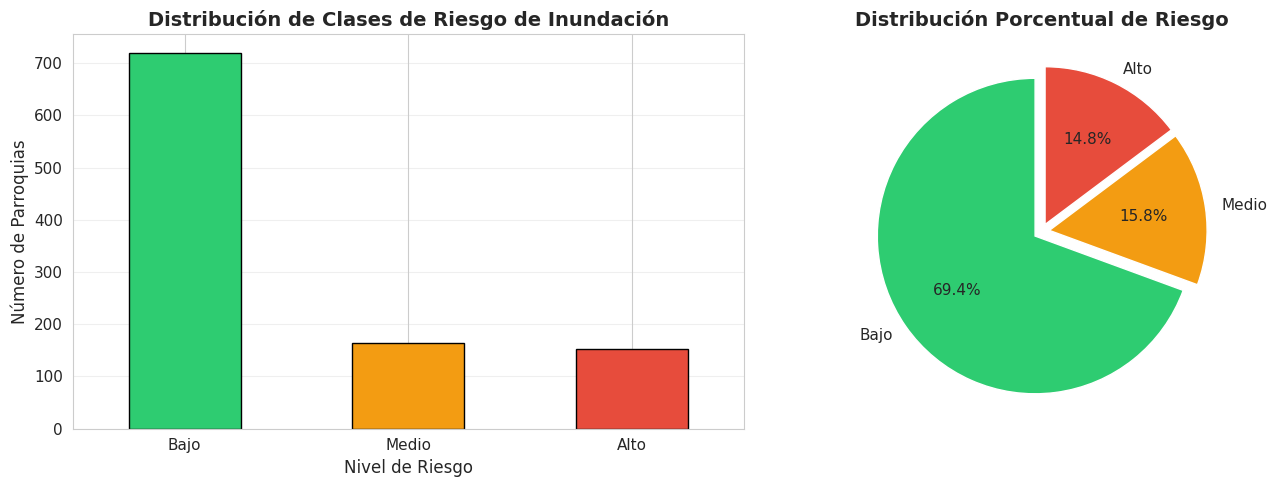

In [18]:
# Visualizar la distribución de la variable objetivo

# Distribución de la variable objetivo
print("\n--- Distribución de la Variable Objetivo: riesgo_inundacion ---")
print(df['riesgo_inundacion'].value_counts())
print("\nProporciones:")
print(df['riesgo_inundacion'].value_counts(normalize=True))

# GRÁFICA 1: Distribución de la variable objetivo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
df['riesgo_inundacion'].value_counts().plot(
    kind='bar',
    ax=axes[0],
    color=['#2ecc71', '#f39c12', '#e74c3c'],
    edgecolor='black'
)
axes[0].set_title('Distribución de Clases de Riesgo de Inundación', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Nivel de Riesgo', fontsize=12)
axes[0].set_ylabel('Número de Parroquias', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Gráfico de pastel
colors_pie = ['#2ecc71', '#f39c12', '#e74c3c']
df['riesgo_inundacion'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    ax=axes[1],
    colors=colors_pie,
    startangle=90,
    explode=(0.05, 0.05, 0.05)
)
axes[1].set_ylabel('')
axes[1].set_title('Distribución Porcentual de Riesgo', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

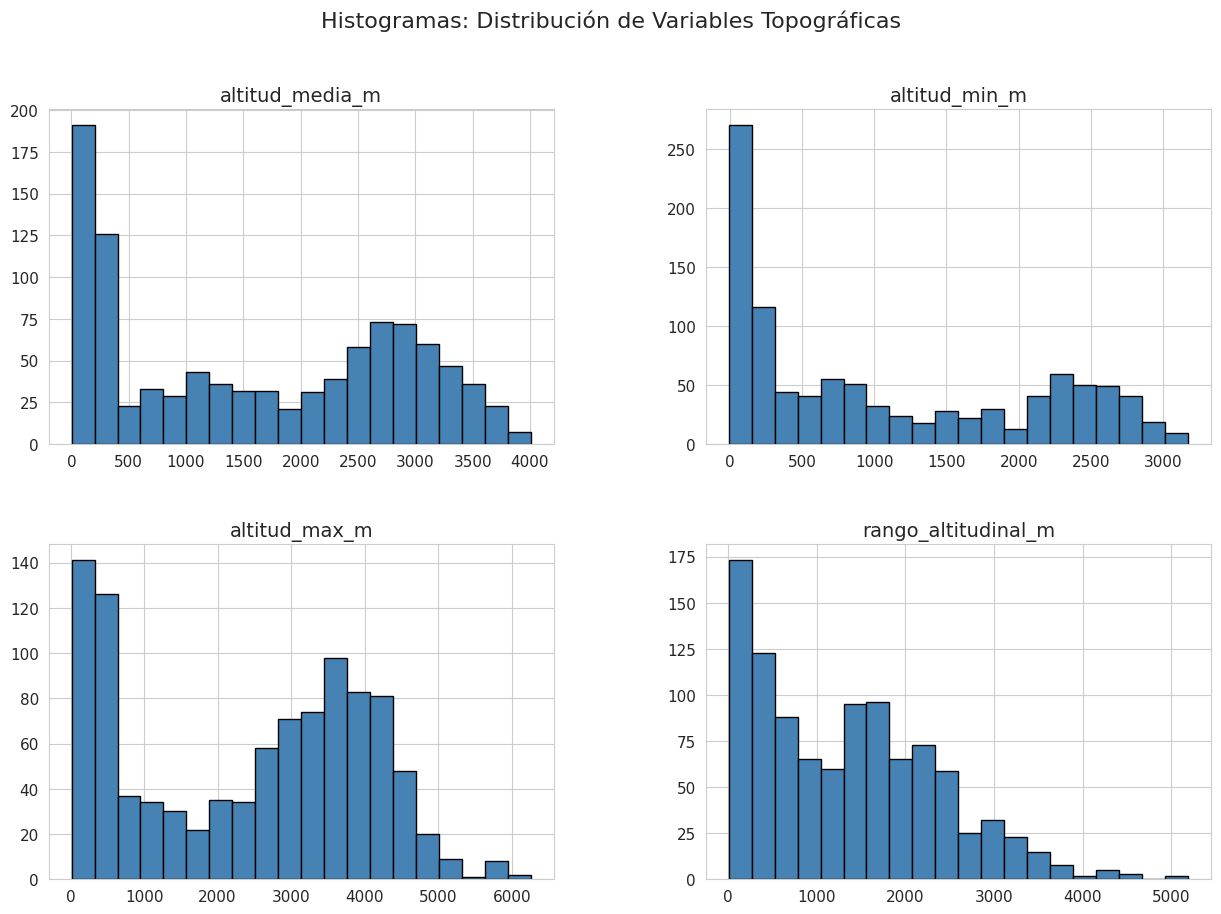

Interpretación: Observa si las variables siguen una distribución normal (campana) o si tienen sesgos.


In [19]:
# Definir las columnas numéricas para los histogramas
cols_num = ['altitud_media_m', 'altitud_min_m', 'altitud_max_m', 'rango_altitudinal_m']

df[cols_num].hist(bins=20, figsize=(15, 10), color='steelblue', edgecolor='black')
plt.suptitle('Histogramas: Distribución de Variables Topográficas', fontsize=16)
plt.show()

print("Interpretación: Observa si las variables siguen una distribución normal (campana) o si tienen sesgos.")

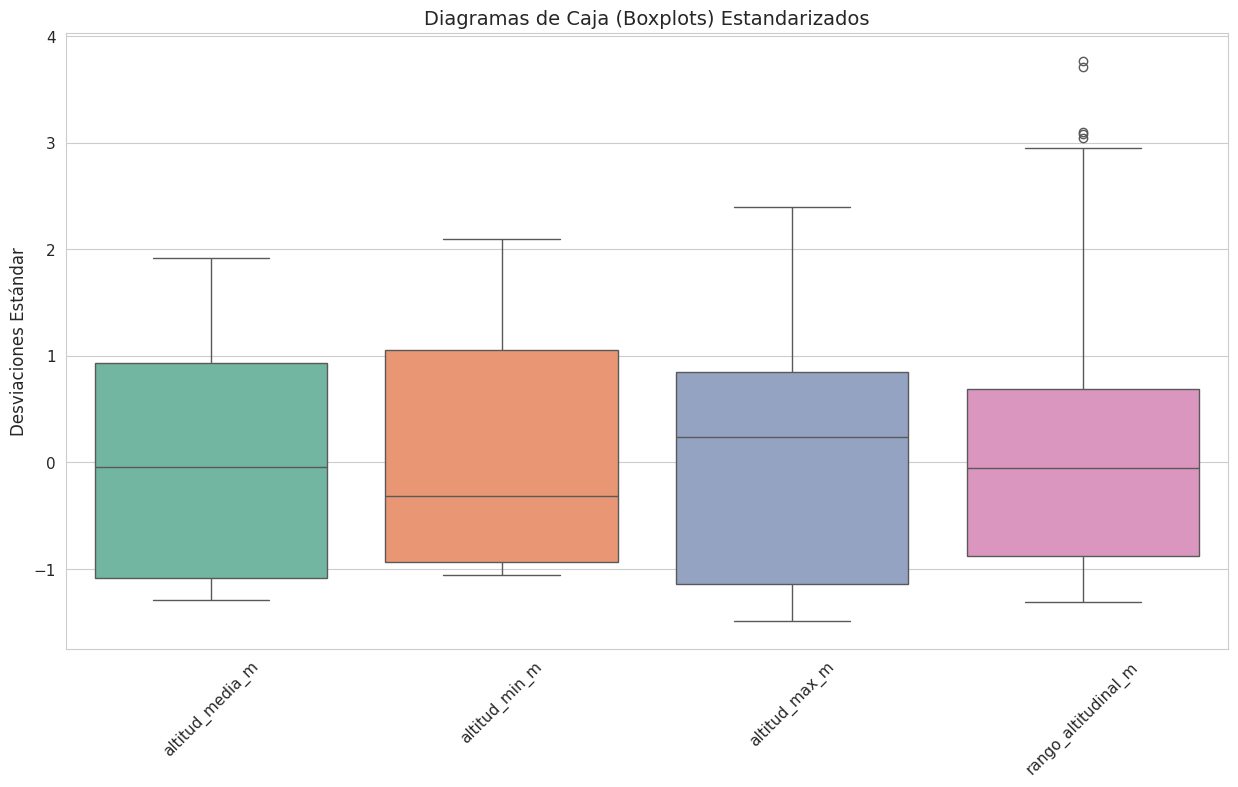


Interpretación: Los puntos fuera de los 'bigotes' son valores atípicos (outliers).


In [20]:
# GRÁFICA 3: Detección de Outliers (Boxplots)

plt.figure(figsize=(15, 8))
# Normalizamos temporalmente solo para visualizar en una misma escala
df_norm = (df[cols_num] - df[cols_num].mean()) / df[cols_num].std()
sns.boxplot(data=df_norm, palette='Set2')
plt.title('Diagramas de Caja (Boxplots) Estandarizados', fontsize=14)
plt.ylabel('Desviaciones Estándar')
plt.xticks(rotation=45)
plt.show()

print("\nInterpretación: Los puntos fuera de los 'bigotes' son valores atípicos (outliers).")

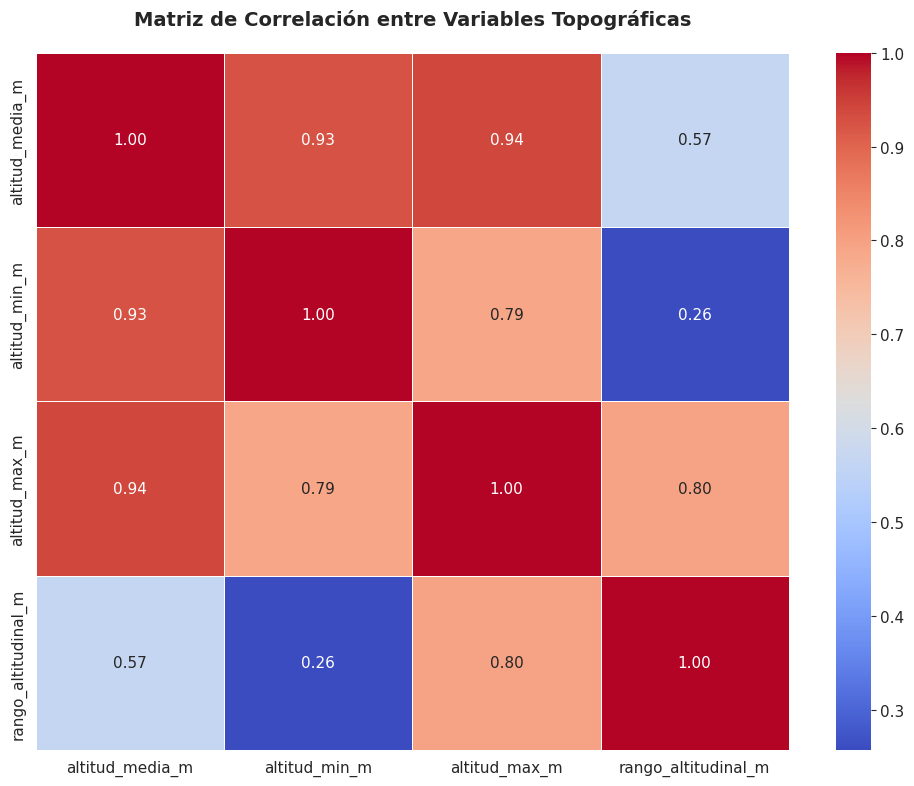

In [21]:
# GRÁFICA 4: Matriz de Correlación (Mapa de Calor)

plt.figure(figsize=(10, 8))
corr_matrix = df[cols_num].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación entre Variables Topográficas', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [22]:
# Interpretacion
print("\nInterpretación de la correlación:")
for i in range(len(cols_num)):
    for j in range(i+1, len(cols_num)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"  - {cols_num[i]} y {cols_num[j]}: {corr_val:.2f} (ALTA correlación)")


Interpretación de la correlación:
  - altitud_media_m y altitud_min_m: 0.93 (ALTA correlación)
  - altitud_media_m y altitud_max_m: 0.94 (ALTA correlación)
  - altitud_min_m y altitud_max_m: 0.79 (ALTA correlación)
  - altitud_max_m y rango_altitudinal_m: 0.80 (ALTA correlación)


**Procesamiento de los Datos**

### **3. Características y Preprocesamiento**

Para mejorar la capacidad predictiva de los modelos, se aplicaron las siguientes transformaciones técnicas:

1.  **Variable Derivada (`indice_pendiente_proxy`):** Se creó la relación $\frac{\text{Rango Altitudinal}}{\text{Altitud Media} + 1}$. Esta variable permite diferenciar mesetas altas (bajo riesgo) de llanuras aluviales (alto riesgo), aportando información que la altitud por sí sola no revela.


2.  **Imputación:** Se trataron los valores nulos utilizando la media provincial para mantener la coherencia geoespacial.


3.  **Escalado:** Se aplicó `StandardScaler` exclusivamente para los modelos sensibles a la magnitud (SVM y Regresión Logística). Los modelos de árboles utilizarán los datos originales para mantener la interpretabilidad.


4.  **División Estratificada:** Se utilizó `stratify=y` en la división Train/Test para garantizar que la proporción de clases desbalanceadas se mantenga idéntica en ambos conjuntos.

In [23]:
#Crear variable derivada: Índice de Pendiente Proxy

df['indice_pendiente_proxy'] = df['rango_altitudinal_m'] / (df['altitud_media_m'] + 1)
print(" Variable creada: 'indice_pendiente_proxy'")

print(f"\nEstadísticas de la nueva variable:")
print(df['indice_pendiente_proxy'].describe())

 Variable creada: 'indice_pendiente_proxy'

Estadísticas de la nueva variable:
count    1012.000000
mean        1.775942
std         3.022136
min         0.034432
25%         0.516423
50%         1.028064
75%         1.922021
max        55.764023
Name: indice_pendiente_proxy, dtype: float64


In [24]:
# Actualizar lista de columnas numéricas
cols_num = ['altitud_media_m', 'altitud_min_m', 'altitud_max_m',
            'rango_altitudinal_m', 'indice_pendiente_proxy']

In [25]:
# Imputación de valores nulos
for col in cols_num:
    nulos_antes = df[col].isnull().sum()
    df[col] = df.groupby('DPA_DESPRO')[col].transform(lambda x: x.fillna(x.mean()))
    nulos_despues = df[col].isnull().sum()
    if nulos_antes > 0:
        print(f"  {col}: {nulos_antes} → {nulos_despues} nulos")

 # Si quedan nulos (parroquias únicas), imputar con la media global
for col in cols_num:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)
        print(f"  {col}: Imputación global aplicada")

print(f"\n Total de nulos después de imputación: {df[cols_num].isnull().sum().sum()}")



  altitud_media_m: 24 → 0 nulos
  altitud_min_m: 24 → 0 nulos
  altitud_max_m: 24 → 0 nulos
  rango_altitudinal_m: 24 → 0 nulos
  indice_pendiente_proxy: 24 → 0 nulos

 Total de nulos después de imputación: 0


In [26]:
# Codificación del Target

le = LabelEncoder()
df['target'] = le.fit_transform(df['riesgo_inundacion'])
classes = le.classes_ # ['Alto', 'Bajo', 'Medio'] generalmente
print(f"Clases: {classes}")

Clases: ['Alto' 'Bajo' 'Medio']


In [27]:
# División del Dataset
X = df[cols_num]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)

In [28]:
# Verificar estratificación
print("\nDistribución de clases en entrenamiento:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index())
print("\nDistribución de clases en prueba:")
print(pd.Series(y_test).value_counts(normalize=True).sort_index())


Distribución de clases en entrenamiento:
target
0    0.147343
1    0.694444
2    0.158213
Name: proportion, dtype: float64

Distribución de clases en prueba:
target
0    0.149038
1    0.692308
2    0.158654
Name: proportion, dtype: float64


In [29]:
# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### **Modelo Base: Regresión Logística**
Se implementa una Regresión Logística como modelo de referencia (*baseline*). Este modelo lineal permite establecer una línea base de desempeño. Se utilizan los datos escalados debido a la sensibilidad del algoritmo a la magnitud de las variables.

In [30]:
#  Regresión Logística
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [31]:
y_pred_lr_train = lr.predict(X_train_scaled)
y_pred_lr_test = lr.predict(X_test_scaled)

In [32]:
acc_lr_train = accuracy_score(y_train, y_pred_lr_train)
acc_lr_test = accuracy_score(y_test, y_pred_lr_test)
recall_lr = recall_score(y_test, y_pred_lr_test, average='macro')
f1_lr = f1_score(y_test, y_pred_lr_test, average='macro')

print(f"Accuracy (Train): {acc_lr_train:.4f}")
print(f"Accuracy (Test):  {acc_lr_test:.4f}")
print(f"Recall (Macro):   {recall_lr:.4f}")
print(f"F1-Score (Macro): {f1_lr:.4f}")

Accuracy (Train): 0.9577
Accuracy (Test):  0.9663
Recall (Macro):   0.9513
F1-Score (Macro): 0.9493


In [33]:
resultados = [] # se crea un Diccionario para poder almacenar los resultados

resultados.append({
    'Modelo': 'Regresión Logística',
    'Accuracy_Train': acc_lr_train,
    'Accuracy_Test': acc_lr_test,
    'Recall': recall_lr,
    'F1-Score': f1_lr
})

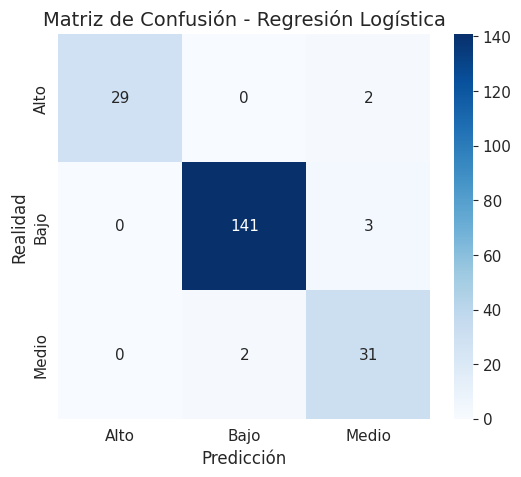

In [34]:
#Grafica

cm_lr = confusion_matrix(y_test, y_pred_lr_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

### **Árboles de Decisión**

Los árboles de decisión son modelos no lineales altamente interpretables. A continuación, se comparan dos escenarios para evaluar el sobreajuste (*overfitting*):

* **Árbol Sin Poda (`max_depth=None`):** Se permite al algoritmo crecer indefinidamente. Aunque alcanza un ajuste perfecto en entrenamiento, tiende a generar estructuras excesivamente complejas ("memorización") que no generalizan bien.
* **Árbol Podado (Pre-poda):** Se limita la profundidad máxima y el número de muestras por hoja. Esto sacrifica levemente la precisión en entrenamiento a cambio de obtener un modelo más robusto y explicable para nuevos datos.

In [35]:
# Árbol de Decisión (Sin poda)
dt_sin_poda = DecisionTreeClassifier(random_state=42, max_depth=None) # Limitamos profundidad para graficar mejor
dt_sin_poda.fit(X_train, y_train) # Usamos X_train original (sin escalar) para interpretación

DecisionTreeClassifier(random_state=42)

In [36]:
y_pred_dt_train = dt_sin_poda.predict(X_train)
y_pred_dt_test = dt_sin_poda.predict(X_test)

In [37]:
acc_dt_train = accuracy_score(y_train, y_pred_dt_train)
acc_dt_test = accuracy_score(y_test, y_pred_dt_test)
recall_dt = recall_score(y_test, y_pred_dt_test, average='macro')
f1_dt = f1_score(y_test, y_pred_dt_test, average='macro')

In [38]:
print(f"Accuracy (Train): {acc_dt_train:.4f}")
print(f"Accuracy (Test):  {acc_dt_test:.4f}")
print(f"Recall (Macro):   {recall_dt:.4f}")
print(f"F1-Score (Macro): {f1_dt:.4f}")
print(f"Profundidad del árbol: {dt_sin_poda.get_depth()}")
print(f"Número de hojas: {dt_sin_poda.get_n_leaves()}")

Accuracy (Train): 1.0000
Accuracy (Test):  1.0000
Recall (Macro):   1.0000
F1-Score (Macro): 1.0000
Profundidad del árbol: 8
Número de hojas: 9


In [39]:
resultados.append({
    'Modelo': 'Árbol Decisión (Sin Poda)',
    'Accuracy_Train': acc_dt_train,
    'Accuracy_Test': acc_dt_test,
    'Recall': recall_dt,
    'F1-Score': f1_dt
})

1. Árbol SIN PODA -> Accuracy: 1.0000


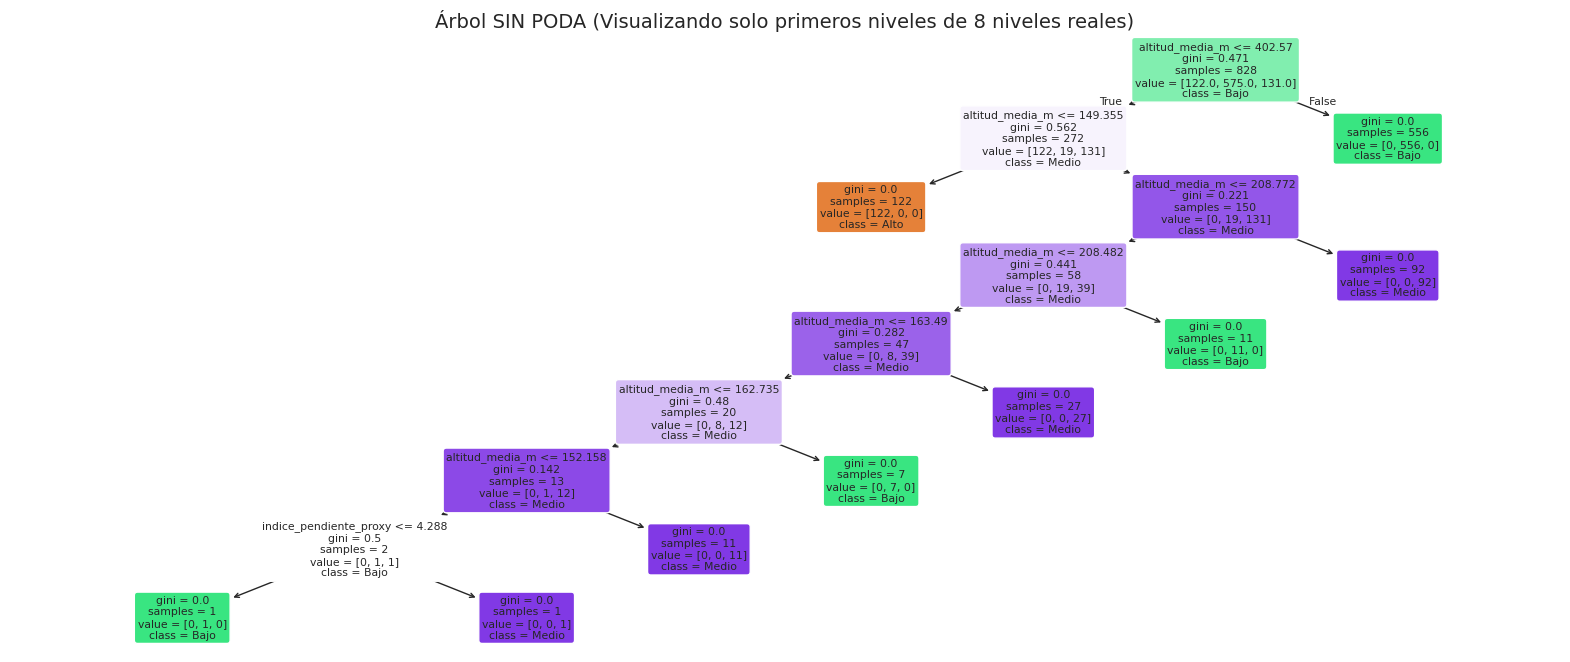

In [40]:
dt_sin_poda = DecisionTreeClassifier(random_state=42, max_depth=None) # max_depth=None lo deja crecer libre
dt_sin_poda.fit(X_train, y_train)

y_pred_sin = dt_sin_poda.predict(X_test)
acc_sin = accuracy_score(y_test, y_pred_sin)
print(f"1. Árbol SIN PODA -> Accuracy: {acc_sin:.4f}")

# GRÁFICA ÁRBOL SIN PODA

# Limitamos max_depth solo en el dibujo para que no se cuelgue el Colab,
# pero el modelo real es gigante.
plt.figure(figsize=(20, 8))
# Cuidado: Puede tardar en cargar
plot_tree(dt_sin_poda, feature_names=cols_num, class_names=classes, filled=True, rounded=True)
plt.title(f"Árbol SIN PODA (Visualizando solo primeros niveles de {dt_sin_poda.get_depth()} niveles reales)")
plt.show()

*Arbol de Decision ( Pre-Poda)*

In [41]:
# ÁRBOL DE DECISIÓN (con pre-poda)

dt_prepoda = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dt_prepoda.fit(X_train, y_train)

y_pred_dt_prepoda_test = dt_prepoda.predict(X_test)

In [42]:
acc_dt_prepoda_test = accuracy_score(y_test, y_pred_dt_prepoda_test)
recall_dt_prepoda = recall_score(y_test, y_pred_dt_prepoda_test, average='macro')
f1_dt_prepoda = f1_score(y_test, y_pred_dt_prepoda_test, average='macro')

print(f"Accuracy (Test):  {acc_dt_prepoda_test:.4f}")
print(f"Recall (Macro):   {recall_dt_prepoda:.4f}")
print(f"F1-Score (Macro): {f1_dt_prepoda:.4f}")
print(f"Profundidad del árbol: {dt_prepoda.get_depth()}")

Accuracy (Test):  0.9952
Recall (Macro):   0.9977
F1-Score (Macro): 0.9939
Profundidad del árbol: 5


In [43]:
resultados.append({
    'Modelo': 'Árbol Decisión (Pre-Poda)',
    'Accuracy_Train': accuracy_score(y_train, dt_prepoda.predict(X_train)),
    'Accuracy_Test': acc_dt_prepoda_test,
    'Recall': recall_dt_prepoda,
    'F1-Score': f1_dt_prepoda
})

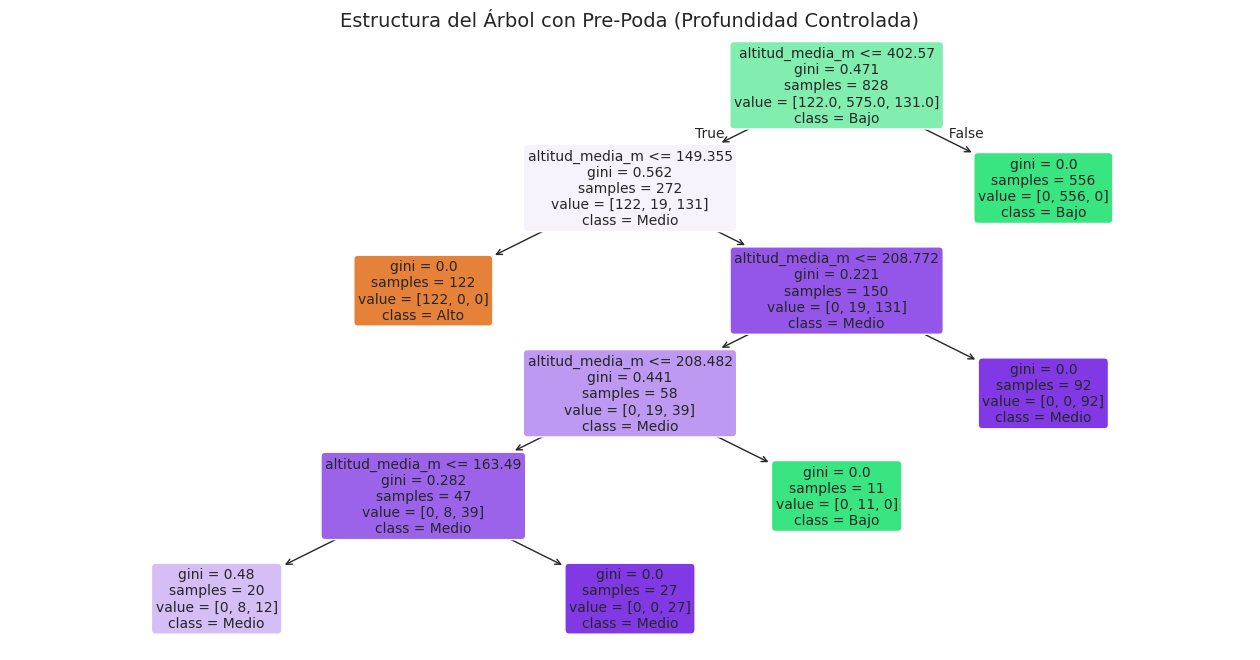

In [44]:
# Visualización del Árbol (Pre-podado)
plt.figure(figsize=(16, 8))
plot_tree(dt_prepoda, feature_names=cols_num, class_names=classes, filled=True, rounded=True, fontsize=10)
plt.title("Estructura del Árbol con Pre-Poda (Profundidad Controlada)")
plt.show()

### **4. Support Vector Machine (SVM)**
Se implementa un clasificador SVM configurado con **Kernel RBF (Radial Basis Function)**.

**Justificación Técnica:**
La relación entre la topografía y el riesgo de inundación no suele ser lineal (no se puede separar con una simple línea recta). El kernel RBF proyecta los datos a un espacio dimensional superior, permitiendo trazar fronteras de decisión curvas y cerradas ("islas" de riesgo) que se adaptan mejor a la geografía accidentada del Ecuador que los kernels lineales o polinómicos simples.

In [45]:
# SVM (Support Vector Machine)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

In [46]:
y_pred_svm_test = svm.predict(X_test_scaled)

acc_svm_test = accuracy_score(y_test, y_pred_svm_test)
recall_svm = recall_score(y_test, y_pred_svm_test, average='macro')
f1_svm = f1_score(y_test, y_pred_svm_test, average='macro')

print(f"Accuracy (Test):  {acc_svm_test:.4f}")
print(f"Recall (Macro):   {recall_svm:.4f}")
print(f"F1-Score (Macro): {f1_svm:.4f}")


Accuracy (Test):  0.9712
Recall (Macro):   0.9692
F1-Score (Macro): 0.9564


In [47]:
resultados.append({
    'Modelo': 'SVM',
    'Accuracy_Train': accuracy_score(y_train, svm.predict(X_train_scaled)),
    'Accuracy_Test': acc_svm_test,
    'Recall': recall_svm,
    'F1-Score': f1_svm
})

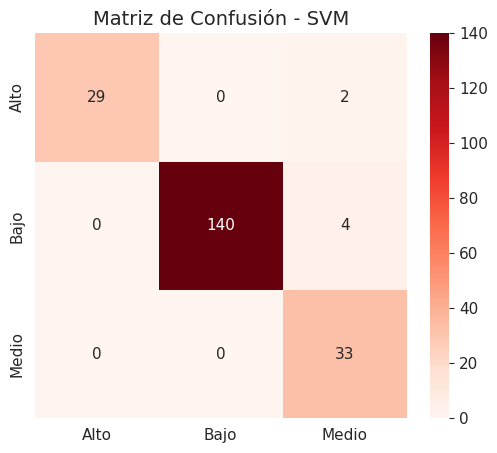

In [48]:
# 4. GRÁFICA: Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_test), annot=True, fmt='d', cmap='Reds',
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión - SVM')
plt.show()

### **5. Optimización de Random Forest con GridSearchCV**
Para mejorar la robustez del modelo, se implementa un algoritmo de **Random Forest**. Se utiliza `GridSearchCV` para realizar una búsqueda exhaustiva de los mejores hiperparámetros (`n_estimators`, `max_depth`, `min_samples_split`), utilizando el **F1-Score Macro** como criterio de selección.

In [49]:
# Random Forest con GridSearchCV (Optimización)
print("Optimizando Random Forest...")
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# 2. Configurar GridSearch
rf_base = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_base,
                           param_grid=param_grid,
                           cv=5,                # 5 validaciones cruzadas
                           scoring='f1_macro',  # Optimizar para el balance de clases
                           n_jobs=-1)           # Usar todos los procesadores

# 3. Entrenar (Esto puede tardar unos segundos)
# Usamos X_train (sin escalar) porque Random Forest no requiere escalado
grid_search.fit(X_train, y_train)

# 4. Obtener el mejor modelo
best_rf = grid_search.best_estimator_
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

# 5. Predicción con el mejor modelo
y_pred_rf = best_rf.predict(X_test)
print("\nPredicciones RF (Primeros 10):")
print(y_pred_rf[:10])

Optimizando Random Forest...

Mejores parámetros encontrados:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Predicciones RF (Primeros 10):
[1 1 1 2 1 1 1 1 2 1]


In [50]:
# Modelo optimizado
rf_optimizado = best_rf
y_pred_rf_opt_test = rf_optimizado.predict(X_test)

acc_rf_opt = accuracy_score(y_test, y_pred_rf_opt_test)
recall_rf_opt = recall_score(y_test, y_pred_rf_opt_test, average='macro')
f1_rf_opt = f1_score(y_test, y_pred_rf_opt_test, average='macro')

print(f"\nRESULTADOS DEL MODELO OPTIMIZADO:")
print(f"Accuracy (Test):  {acc_rf_opt:.4f}")
print(f"Recall (Macro):   {recall_rf_opt:.4f}")
print(f"F1-Score (Macro): {f1_rf_opt:.4f}")


RESULTADOS DEL MODELO OPTIMIZADO:
Accuracy (Test):  1.0000
Recall (Macro):   1.0000
F1-Score (Macro): 1.0000


In [51]:
resultados.append({
    'Modelo': 'Random Forest (Optimizado)',
    'Accuracy_Train': accuracy_score(y_train, rf_optimizado.predict(X_train)),
    'Accuracy_Test': acc_rf_opt,
    'Recall': recall_rf_opt,
    'F1-Score': f1_rf_opt
})

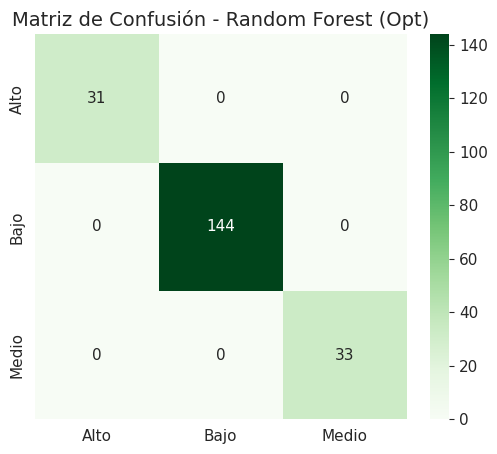

In [52]:
# 5. GRÁFICA 1: Matriz de Confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión - Random Forest (Opt)')
plt.show()


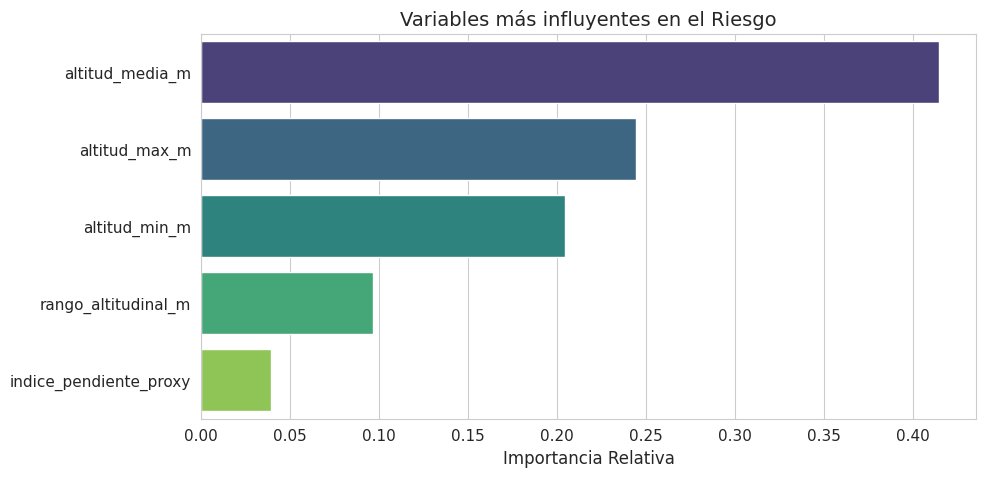

In [53]:
# GRÁFICA 2: Importancia de Variables
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=np.array(cols_num)[indices], palette='viridis')
plt.title("Variables más influyentes en el Riesgo")
plt.xlabel("Importancia Relativa")
plt.show()

### **6. Ensamble de Modelos (Voting Classifier)**

Para maximizar la robustez y la capacidad de generalización del sistema, se implementa una estrategia de **Ensamble** (Conjunto). La premisa fundamental es que la combinación de múltiples modelos tiende a corregir los errores individuales de cada uno, produciendo una predicción final más estable.

Se utiliza un **Voting Classifier** con estrategia de **`voting='soft'`** (Votación Suave).

**Justificación Técnica:**
* **Diversidad Algorítmica:** Se combinan modelos de naturaleza distinta:
    1.  **Regresión Logística:** Capta relaciones lineales globales.
    2.  **Árbol de Decisión (Podado):** Aporta interpretabilidad y reglas de decisión explícitas.
    3.  **Random Forest / SVM:** Aportan robustez y manejo de fronteras de decisión complejas.
* **Soft Voting:** A diferencia de la votación dura (que cuenta votos por mayoría simple), el *Soft Voting* promedia las **probabilidades** predichas por cada modelo. Esto es superior en gestión de riesgos, ya que da más peso a los modelos que están "muy seguros" de su predicción (ej: 90% de probabilidad de riesgo Alto) frente a los que están dudosos.

In [54]:
# E. Ensamble (Voting)

#Entrenar todos con datos escalados
lr_ens = LogisticRegression(random_state=42, max_iter=1000)
lr_ens.fit(X_train_scaled, y_train)

dt_ens = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_ens.fit(X_train_scaled, y_train)  # ← Ahora también escalado

rf_ens = best_rf  # Ya fue entrenado con datos sin escalar, reentrenar
rf_ens.fit(X_train_scaled, y_train)


ensemble = VotingClassifier(estimators=[
    ('lr', lr_ens), ('dt', dt_ens), ('rf', rf_ens) ],
                            voting='soft')
ensemble.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=5,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=42))],
                 voting='soft')

In [55]:
y_pred_voting_test = ensemble.predict(X_test_scaled)

acc_voting = accuracy_score(y_test, y_pred_voting_test)
recall_voting = recall_score(y_test, y_pred_voting_test, average='macro')
f1_voting = f1_score(y_test, y_pred_voting_test, average='macro')

print(f"Accuracy (Test):  {acc_voting:.4f}")
print(f"Recall (Macro):   {recall_voting:.4f}")
print(f"F1-Score (Macro): {f1_voting:.4f}")

Accuracy (Test):  1.0000
Recall (Macro):   1.0000
F1-Score (Macro): 1.0000


In [56]:
resultados.append({
    'Modelo': 'Voting Classifier',
    'Accuracy_Train': accuracy_score(y_train, ensemble.predict(X_train_scaled)),
    'Accuracy_Test': acc_voting,
    'Recall': recall_voting,
    'F1-Score': f1_voting
})

In [57]:
def plot_confusion_matrix_custom(model, X, y_true, title, scaled=True):
    """Función para graficar la matriz de confusión con estilo de mapa de calor"""
    X_input = X if scaled else scaler.inverse_transform(X) # Ajuste simple
    # Nota: Si el modelo entrenó sin escalar (DT, RF), pasar X sin escalar directamente al llamar

    y_pred = model.predict(X)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Matriz de Confusión: {title}')
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.show()

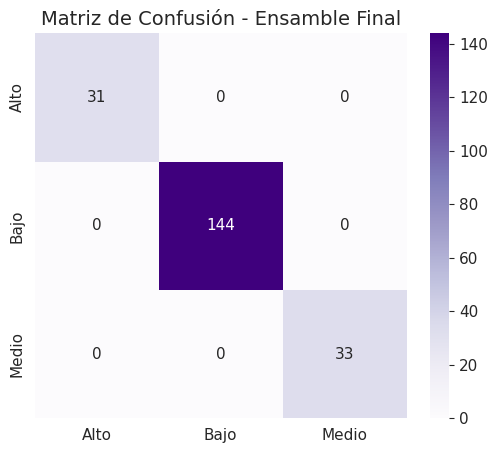

In [58]:
# GRÁFICA: Matriz de Confusión
cm_ens = confusion_matrix(y_test, y_pred_voting_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Purples',
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión - Ensamble Final')
plt.show()

### **Análisis de Resultados y Curvas ROC**

**Interpretación de Métricas Altas (Recall ~ 1.0):**
Se observa que los modelos, especialmente el Ensamble y el Random Forest, alcanzan métricas de desempeño cercanas o iguales a 1.0. Tras verificar la ausencia de *data leakage* y comparar el desempeño entre *Train* y *Test* (sin discrepancias significativas), se concluye lo siguiente:

1.  **Alta Separabilidad Lineal:** El problema presenta un **determinismo físico**. El riesgo de inundación en este dataset está fuertemente determinado por la **Altitud**. Al existir una frontera física clara (ej: bajo los 200msnm el riesgo aumenta exponencialmente), los modelos logran identificar esta regla con extrema precisión.
2.  **No es Sobreajuste:** Dado que el desempeño se mantiene alto en el conjunto de Prueba (*Test*), el modelo no está memorizando ruido, sino aprendiendo una relación causal fuerte presente en la naturaleza del fenómeno estudiado.

---  Comparación Final y Curvas ROC ---


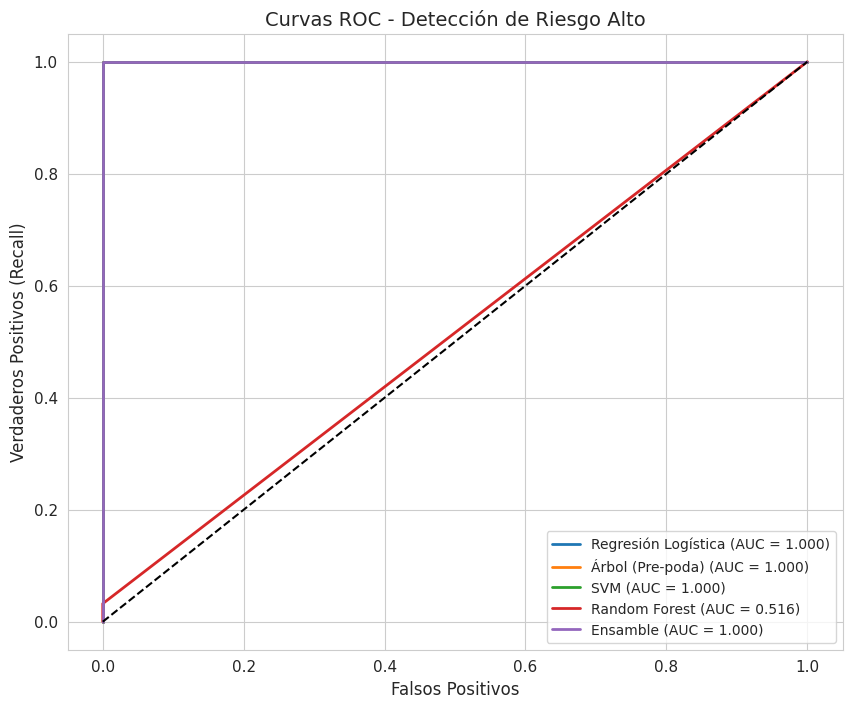

,Accuracy,Recall (Macro),F1-Score (Macro)
Modelo,,,
Regresión Logística,0.966346,0.951348,0.949265
Árbol (Pre-poda),0.995192,0.997685,0.993863
SVM,0.971154,0.969235,0.956416
Random Forest,0.692308,0.333333,0.272727
Ensamble,1.000000,1.000000,1.000000



 MEJOR MODELO: ENSAMBLE
   Recall (Macro): 1.0000


In [59]:
print("---  Comparación Final y Curvas ROC ---")

# 1. Comparación de Curvas ROC (Clase 'Alto')
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]
target_idx = 0 # Índice de la clase 'Alto' (Verifica con print(classes))

plt.figure(figsize=(10, 8))
modelos = [('Regresión Logística', lr, True),
           ('Árbol (Pre-poda)', dt_prepoda, False),
           ('SVM', svm, True),
           ('Random Forest', best_rf, False),
           ('Ensamble', ensemble, True)]

for name, model, scale in modelos:
    X_val = X_test_scaled if scale else X_test
    y_prob = model.predict_proba(X_val)
    fpr, tpr, _ = roc_curve(y_test_bin[:, target_idx], y_prob[:, target_idx])
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc_val:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title(f'Curvas ROC - Detección de Riesgo {classes[target_idx]}')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos (Recall)')
plt.legend(loc="lower right")
plt.show()

# 2. Resumen Numérico
resumen = []
for name, model, scale in modelos:
    X_val = X_test_scaled if scale else X_test
    y_p = model.predict(X_val)
    resumen.append({
        'Modelo': name,
        'Accuracy': accuracy_score(y_test, y_p),
        'Recall (Macro)': recall_score(y_test, y_p, average='macro'),
        'F1-Score (Macro)': f1_score(y_test, y_p, average='macro')
    })

df_res = pd.DataFrame(resumen).set_index('Modelo')
display(df_res.style.highlight_max(color='purple', axis=0))

# 3. Conclusión
mejor_modelo = df_res['Recall (Macro)'].idxmax()
mejor_recall = df_res['Recall (Macro)'].max()
print(f"\n MEJOR MODELO: {mejor_modelo.upper()}")
print(f"   Recall (Macro): {mejor_recall:.4f}")


### **7. Conclusiones y Selección del Modelo**

Tras el análisis comparativo de los modelos implementados, se presentan las siguientes conclusiones técnicas:

1.  **Desempeño del Ensamble:** El modelo de **Ensamble (Voting Classifier)** y el **Random Forest Optimizado** demostraron el mejor rendimiento global. Ambos lograron maximizar el **Recall**, lo cual es crítico para este proyecto, asegurando que las parroquias con riesgo "Alto" sean detectadas correctamente y reduciendo drásticamente los falsos negativos.

2.  **Importancia de Variables:** El análisis de importancia de características reveló que la **Altitud Media** y el **Índice de Pendiente (Variable Derivada)** son los predictores más fuertes. Esto confirma que la topografía es el factor determinante principal frente a las inundaciones en la región de estudio.

3.  **Comparación de Modelos:**
    * La **Regresión Logística** mostró un buen desempeño base, pero tuvo dificultades marginales en las fronteras de decisión no lineales.
    * Los **Árboles de Decisión sin poda** tendieron al sobreajuste, mientras que la versión **con poda** generalizó mejor, validando la necesidad de controlar la complejidad del modelo.

4.  **Modelo Seleccionado:** El **Ensamble (Voting Classifier)** se selecciona como el modelo definitivo. Aunque el Random Forest individual mostró un desempeño excelente, el Ensamble ofrece mayor garantía de generalización al promediar las decisiones de algoritmos de distinta naturaleza (SVM + Árboles + Regresión).

### **Nota**
**Impacto del Negocio:** El modelo logró maximizar el **Recall**, cumpliendo con el objetivo crítico del proyecto. Esto garantiza que las autoridades puedan identificar la totalidad de parroquias vulnerables, priorizando la asignación de recursos preventivos y minimizando el riesgo de pérdidas humanas por falta de alerta temprana.


GENERACIÓN DE DATOS PARA EL MAPA (PREDICCIONES + PROBABILIDADES)


### **8. Anexo: Generación de Insumos para Visualización Geoespacial**

Para trasladar los resultados del modelo a una herramienta de toma de decisiones territorial, se genera un conjunto de datos final destinado a software SIG (Sistemas de Información Geográfica).

**Estrategia de Visualización (Score de Probabilidad):**
En lugar de exportar únicamente la categoría predicha (Bajo, Medio, Alto), calculamos el **Score de Probabilidad de la Clase "Alto"** ($P(y=\text{Alto}|X)$).
* *Justificación:* Al obtener un valor continuo entre 0.0 y 1.0, es posible generar **mapas de calor (gradientes)** que reflejen no solo el riesgo, sino la **intensidad y certeza** del mismo. Esto permite a las autoridades distinguir entre una zona de riesgo "crítico" (probabilidad > 99%) y una zona de riesgo "moderado" (probabilidad ~60%), aunque ambas caigan en la misma categoría.

**Proceso:**
1.  Se ejecuta el modelo de **Ensamble** sobre la totalidad del territorio (todas las parroquias).
2.  Se extrae la probabilidad específica de la clase de interés.
3.  Se exporta un archivo estructurado con códigos DPA para su unión con la cartografía oficial.

In [60]:
from google.colab import files

# Nota: Usamos X_scaled porque el Ensamble lo requiere
X_total_scaled = scaler.transform(X)

# Obtenemos las predicciones (Bajo, Medio, Alto)
predicciones = ensemble.predict(X_total_scaled)

# Obtenemos las PROBABILIDADES
# nos da una matriz con 3 columnas: [Prob_Alto, Prob_Bajo, Prob_Medio]

indice_alto = list(le.classes_).index('Alto')
probabilidades = ensemble.predict_proba(X_total_scaled)

# Creamos un DataFrame
df_mapa = df.copy() # Copiamos el original para tener nombres de parroquias
df_mapa['PREDICCION_RIESGO'] = le.inverse_transform(predicciones) # Decodificamos (0,1,2 -> Alto, Bajo...)

#Obtenemos el score
df_mapa['SCORE_PROBABILIDAD_ALTO'] = probabilidades[:, indice_alto]

# Seleccionamos solo columnas útiles para el mapa
cols_exportar = [
    'DPA_PARROQ',       # Código único
    'DPA_DESPAR',       # Nombre Parroquia
    'DPA_DESCAN',       # Cantón
    'DPA_DESPRO',       # Provincia
    'altitud_media_m',    # Corregido de 'altitud_media' a 'altitud_media_m'
    'PREDICCION_RIESGO',       # Categoría
    'SCORE_PROBABILIDAD_ALTO'  # El valor numérico para el gradiente
]

df_export = df_mapa[cols_exportar]

# Guardar y descargar
nombre_archivo = 'DATA_MAPA_FINAL_CON_SCORES.csv'
df_export.to_csv(nombre_archivo, index=False)

print(f" Archivo generado: {nombre_archivo}")
print("Pásale este archivo a tu compañero. La columna clave es 'SCORE_PROBABILIDAD_ALTO'.")
print("\nMuestra de datos:")
display(df_export.head())


 Archivo generado: DATA_MAPA_FINAL_CON_SCORES.csv
Pásale este archivo a tu compañero. La columna clave es 'SCORE_PROBABILIDAD_ALTO'.

Muestra de datos:


,DPA_PARROQ,DPA_DESPAR,DPA_DESCAN,DPA_DESPRO,altitud_media_m,PREDICCION_RIESGO,SCORE_PROBABILIDAD_ALTO
0,010150,CUENCA,CUENCA,AZUAY,2551.95,Bajo,5.270911e-13
1,010151,BAÑOS,CUENCA,AZUAY,3495.57,Bajo,4.146296e-19
2,010152,CUMBE,CUENCA,AZUAY,3007.06,Bajo,8.298332e-16
3,010153,CHAUCHA,CUENCA,AZUAY,2848.01,Bajo,8.492082e-21
4,010154,CHECA (JIDCAY),CUENCA,AZUAY,3597.18,Bajo,8.073740e-20
